# Lets make a competition of models and determine if the response is predicted best using linear models or non-liner decision boundaries on our engineered feature set of frequency features of windowed EEG data


In [1]:
# Read the data
import pandas as pd

df = pd.read_csv('segments_fs_width_50pct_overlap_DTAB_GT.csv')

df.head()

,delta,theta,alpha,beta,seizure
0,0.995975,0.075758,0.043777,0.019427,0
1,0.992658,0.111096,0.044879,0.016525,0
2,0.993037,0.108308,0.040143,0.023155,0
3,0.763365,0.570391,0.243744,0.180323,0
4,0.864663,0.453227,0.206527,0.065492,0


In [2]:
# convert seizure type to categorical
df['seizure'] = df['seizure'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   delta    125 non-null    float64 
 1   theta    125 non-null    float64 
 2   alpha    125 non-null    float64 
 3   beta     125 non-null    float64 
 4   seizure  125 non-null    category
dtypes: category(1), float64(4)
memory usage: 4.3 KB


In [4]:
! pip install lazypredict

In [5]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

X = df.drop('seizure', axis=1)
y = df['seizure']

# Assuming you have your data in X (features) and y (target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True)

# Fit and compare models
# models_train, predictions_train = clf.fit(X_train, X_train, y_train, y_train)
models_test, predictions_test = clf.fit(X_train, X_test, y_train, y_test)

# Print results
print(models_test)


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
100%|██████████| 32/32 [00:02<00:00, 11.94it/s]

[LightGBM] [Info] Number of positive: 55, number of negative: 45
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 140
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.550000 -> initscore=0.200671
[LightGBM] [Info] Start training from score 0.200671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

# Lets now pick one good model type and build a set of model across all the data using 5 fold cross validation and obtain ROC curves etc.

Cross-validation results:
   Sensitivity  Specificity  Precision  AUC
0         0.90         0.60       0.60 0.79
1         0.62         0.58       0.62 0.63
2         0.75         0.69       0.69 0.79
3         0.64         0.64       0.69 0.64
4         0.71         0.27       0.56 0.48
Mean Sensitivity: 0.7245054945054945
Mean Specificity: 0.5569463869463869
Mean Precision: 0.6311111111111112
Mean AUC: 0.6679234099234098


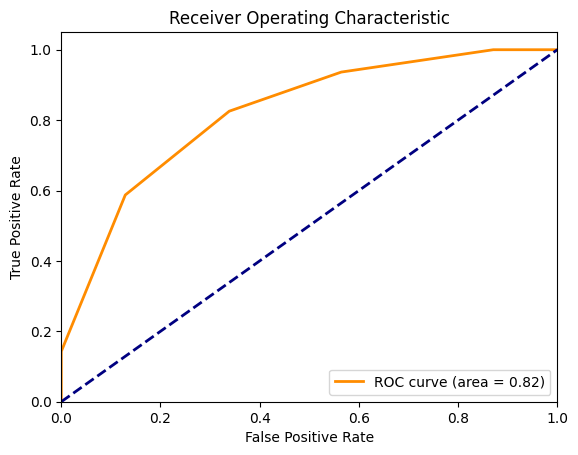

,TPR,FPR,Threshold
0,0.00,0.00,inf
1,0.14,0.00,1.00
2,0.59,0.13,0.80
3,0.83,0.34,0.60
4,0.94,0.56,0.40
5,1.00,0.87,0.20
6,1.00,1.00,0.00


In [8]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt

# Initialize KNN classifier
knn = KNeighborsClassifier()

# Perform 5-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42) #setting random state for reproducibility

# Cross-validation predictions
y_pred = cross_val_predict(knn, X, y, cv=kfold, method='predict_proba')[:, 1]

# Initialize lists to store metrics for each fold
sensitivity_list = []
specificity_list = []
precision_list = []
auc_list = []

# Compute metrics for each fold
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index] # Use iloc to select rows
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] # Use iloc to select rows


    knn.fit(X_train, y_train)
    y_pred_fold = knn.predict(X_test)
    y_prob_fold = knn.predict_proba(X_test)[:, 1]

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_fold).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = precision_score(y_test, y_pred_fold)
    fpr, tpr, _ = roc_curve(y_test, y_prob_fold)
    roc_auc = auc(fpr, tpr)

    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)
    precision_list.append(precision)
    auc_list.append(roc_auc)

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Sensitivity': sensitivity_list,
    'Specificity': specificity_list,
    'Precision': precision_list,
    'AUC': auc_list
})

print("Cross-validation results:")
print(results_df)
print("Mean Sensitivity:", results_df['Sensitivity'].mean())
print("Mean Specificity:", results_df['Specificity'].mean())
print("Mean Precision:", results_df['Precision'].mean())
print("Mean AUC:", results_df['AUC'].mean())

# Fit the model on the entire dataset
knn.fit(X, y)

# Predict probabilities for the positive class
y_prob = knn.predict_proba(X)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y, y_prob)
roc_auc = auc(fpr, tpr)

# Create a DataFrame with TPR, FPR, and thresholds
roc_results_df = pd.DataFrame({'TPR': tpr, 'FPR': fpr, 'Threshold': thresholds})

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

roc_results_df

Cross-validation results:
   Sensitivity  Specificity  Precision  AUC
0         0.90         0.60       0.60 0.79
1         0.62         0.58       0.62 0.63
2         0.75         0.69       0.69 0.79
3         0.64         0.64       0.69 0.64
4         0.71         0.27       0.56 0.48
Mean Sensitivity: 0.7245054945054945
Mean Specificity: 0.5569463869463869
Mean Precision: 0.6311111111111112
Mean AUC: 0.6679234099234098


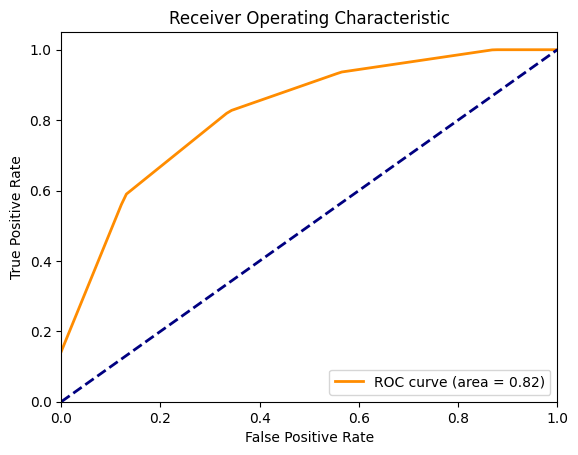

,TPR,FPR,Threshold,Specificity
0,0.14,0.00,1.00,1.00
1,0.18,0.01,0.98,0.99
2,0.21,0.02,0.97,0.98
3,0.25,0.03,0.95,0.97
4,0.28,0.04,0.94,0.96
5,0.32,0.05,0.92,0.95
6,0.35,0.06,0.91,0.94
7,0.39,0.07,0.89,0.93
8,0.42,0.08,0.87,0.92
9,0.46,0.09,0.86,0.91


In [11]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Initialize KNN classifier
knn = KNeighborsClassifier()

# Perform 5-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42) #setting random state for reproducibility

# Cross-validation predictions
y_pred = cross_val_predict(knn, X, y, cv=kfold, method='predict_proba')[:, 1]

# Initialize lists to store metrics for each fold
sensitivity_list = []
specificity_list = []
precision_list = []
auc_list = []

# Compute metrics for each fold
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index] # Use iloc to select rows
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] # Use iloc to select rows

    knn.fit(X_train, y_train)
    y_pred_fold = knn.predict(X_test)
    y_prob_fold = knn.predict_proba(X_test)[:, 1]

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_fold).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = precision_score(y_test, y_pred_fold)
    fpr, tpr, _ = roc_curve(y_test, y_prob_fold)
    roc_auc = auc(fpr, tpr)

    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)
    precision_list.append(precision)
    auc_list.append(roc_auc)

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Sensitivity': sensitivity_list,
    'Specificity': specificity_list,
    'Precision': precision_list,
    'AUC': auc_list
})

print("Cross-validation results:")
print(results_df)
print("Mean Sensitivity:", results_df['Sensitivity'].mean())
print("Mean Specificity:", results_df['Specificity'].mean())
print("Mean Precision:", results_df['Precision'].mean())
print("Mean AUC:", results_df['AUC'].mean())

# Fit the model on the entire dataset
knn.fit(X, y)

# Predict probabilities for the positive class
y_prob = knn.predict_proba(X)[:, 1]

# Compute ROC curve and AUC with at least 100 points
fpr, tpr, thresholds = roc_curve(y, y_prob)
roc_auc = auc(fpr, tpr)

# Interpolate to get at least 100 points
fpr_interp = np.linspace(0, 1, 100)
tpr_interp = np.interp(fpr_interp, fpr, tpr)
thresholds_interp = np.interp(fpr_interp, fpr, thresholds)

# Create a DataFrame with TPR, FPR, and thresholds
roc_results_df = pd.DataFrame({'TPR': tpr_interp, 'FPR': fpr_interp, 'Threshold': thresholds_interp})

roc_results_df['Specificity'] = 1 - roc_results_df['FPR']

# Plot the ROC curve
plt.figure()
plt.plot(fpr_interp, tpr_interp, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

pd.set_option('display.max_rows', None)

roc_results_df

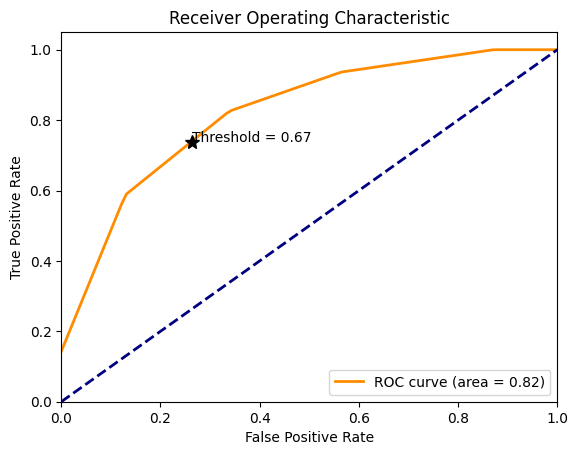

In [17]:
# prompt: update the roc curve to plot a star in black for the point where tpr is equal to specificity per roc_results_df

import matplotlib.pyplot as plt
# Find the point where TPR equals specificity
tpr_specificity_df = roc_results_df[round(roc_results_df['TPR'],2) == round(roc_results_df['Specificity'],2)]
# use the first row
tpr_specificity_df = tpr_specificity_df.head(1)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_interp, tpr_interp, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Plot the star if a point exists where TPR equals specificity
if not tpr_specificity_df.empty:
    plt.plot(tpr_specificity_df['FPR'].iloc[0], tpr_specificity_df['TPR'].iloc[0], '*', color='black', markersize=10)
    # add a label for that point with the value of the threshold itself from roc_results_df
    plt.text(tpr_specificity_df['FPR'].iloc[0], tpr_specificity_df['TPR'].iloc[0], f"Threshold = {round(tpr_specificity_df['Threshold'].iloc[0],2)}", fontsize=10)

plt.show()
